In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
import random
from itertools import product

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.layer import *
# from src.random_search import *
from src.loss_functions import *
from src.model_regularization import *
from src.neural_network import *
from src.optimizers import *
from src.utils import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [4]:
MONK_NUM=3
X_train, y_train = load_data(MONK_NUM)

one hot encoded data:  (122, 17)


In [5]:
X_test, y_test = load_data(MONK_NUM, train=False)

one hot encoded data:  (432, 17)


In [6]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
# # df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
# #                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# df.set_index("index", inplace=True)
# y = df.iloc[:, 0]  # First column as target
# X = df.iloc[:, 1:]  # All other columns as features
# for i in range(1, X.shape[1]):
#     X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
#         np.std(X.iloc[:, i])
# X.head()

########################################################
### Don't forget to change the path to the data file ###
########################################################

# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
#                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# # df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
# #                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# df.set_index("index", inplace=True)
# y = df.iloc[:, 0]  # First column as target
# X = df.iloc[:, 1:]  # All other columns as features
# for i in range(1, X.shape[1]):
#     X.iloc[:, i] = X.iloc[:, i].astype('float64')
#     X.iloc[:, i] = ((X.iloc[:, i] - np.mean(X.iloc[:, i])) /
#                     np.std(X.iloc[:, i]))
# X.head()

In [7]:
# ########################################################
# ### Don't forget to change the path to the data file ###
# ########################################################

# test_data = pd.read_csv("../ML_project/data/Monk_2/monks-2.test",
# names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# test_data.set_index("index", inplace=True)
# # test_data.head()
# y_test = test_data.iloc[:, 0]
# X_test = test_data.iloc[:, 1:]
# for i in range(1, X_test.shape[1]):
#     X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])

########################################################
### Don't forget to change the path to the data file ###
########################################################

# test_data = pd.read_csv("../ML_project/data/Monk_2/monks-2.test",
#                         names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
# test_data.set_index("index", inplace=True)
# # test_data.head()
# y_test = test_data.iloc[:, 0]
# X_test = test_data.iloc[:, 1:]
# for i in range(1, X_test.shape[1]):
#     X_test.iloc[:, i] = ((X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) /
#                          np.std(X_test.iloc[:, i]))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)

Training Features Shape: (97, 17)
Validation Features Shape: (25, 17)
Training Target Shape: (97,)
Validation Target Shape: (25,)


In [9]:
def accuracy(target, output):
    predictions = np.round(output.squeeze())
    return np.mean(predictions == target.squeeze()) * 100

In [10]:
def train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation):
    # Initialize components
    model = NN(
        l1=l1,
        l2=l2,
        input_size=17,
        hidden_sizes=[10],
        output_size=2,
        hidden_activations=[activation],
        dropout_rates=[dropout_rate]
    )
    
    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
    optimizer = Optimizer_Adam(learning_rate=learning_rate)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        batch_losses = []
        batch_accuracies = []
        
        for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
            # Forward pass through model
            model.forward(X_batch, training=True)
            
            # Calculate loss through separate loss activation
            loss = loss_activation.forward(model.output, y_batch)
            # Calculate accuracy
            predictions = np.argmax(loss_activation.output, axis=1)
            accuracy = np.mean(predictions == y_batch)
            
            # Backward pass
            loss_activation.backward(loss_activation.output, y_batch)
            dvalues = loss_activation.dinputs
            
            # Propagate gradients through model layers in reverse
            for layer in reversed(model.layers):
                layer.backward(dvalues)
                dvalues = layer.dinputs
                
                # # Apply L1/L2 regularization to dense layers
                # if isinstance(layer, Layer_Dense):
                #     if layer.l1 > 0:
                #         layer.dweights += layer.l1 * np.sign(layer.weights)
                #     if layer.l2 > 0:
                #         layer.dweights += 2 * layer.l2 * layer.weights
            
            # Update parameters
            optimizer.pre_update_params()
            for layer in model.layers:
                if isinstance(layer, Layer_Dense):
                    optimizer.update_params(layer)
            optimizer.post_update_params()
            
            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

        # Epoch metrics
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation pass
        model.forward(X_val, training=False)
        val_loss = loss_activation.forward(model.output, y_val)
        val_predictions = np.argmax(loss_activation.output, axis=1)
        val_accuracy = np.mean(val_predictions == y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return model, val_accuracies[-1]

In [11]:
# class EnsembleNN:
#     def __init__(self, n_models=5):
#         self.models = []
#         self.n_models = n_models
#         self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#     def create_and_train_models(self, hyperparams):
#         # Create and train multiple models with the same hyperparameters
#         for i in range(self.n_models):
#             print(f"Training model {i+1}/{self.n_models}")
#             # Train model using existing train_and_evaluate function
#             model, val_accuracy = train_and_evaluate(
#                 learning_rate=hyperparams['learning_rate'],
#                 l1=hyperparams['l1'],
#                 l2=hyperparams['l2'],
#                 dropout_rate=hyperparams['dropout_rate'],
#                 batch_size=hyperparams['batch_size'],
#                 n_epochs=hyperparams['n_epochs'],
#                 activation=hyperparams['activation']
#             )
#             self.models.append(model)
#             print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")
    
#     def predict(self, X):
#         """Make predictions using majority voting"""
#         predictions = []
#         for model in self.models:
#             model.forward(X, training=False)
#             self.loss_activation.forward(model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
#             pred = np.argmax(self.loss_activation.output, axis=1)
#             predictions.append(pred)
        
#         # Majority voting
#         predictions = np.array(predictions)
#         final_predictions = np.apply_along_axis(
#             lambda x: np.bincount(x).argmax(), 
#             axis=0, 
#             arr=predictions
#         )
#         return final_predictions


In [12]:
## This is grid search. had to comment it.

# hyperparameter_grid = {
#     'learning_rate': [0.001],
#     'l1': [0.0, 1e-5],
#     'l2': [0.0, 1e-4],
#     'dropout_rate': [0.1, 0.5],
#     'batch_size': [4],
#     'n_epochs': [100, 200],
#     'activation': [Activation_Sigmoid, Activation_Leaky_ReLU]
# }

In [13]:
# Random search for finding the best hyperparameters
def random_search(param_distributions, n_iters):
    best_hyperparams = None
    best_performance = -np.inf
    
    for _ in range(n_iters):
        # Let's have sample hyperparameters from distributions
        params = {
            'learning_rate': random.choice(param_distributions['learning_rate']),
            'l1': random.choice(param_distributions['l1']),
            'l2': random.choice(param_distributions['l2']),
            'dropout_rate': random.choice(param_distributions['dropout_rate']),
            'batch_size': random.choice(param_distributions['batch_size']),
            'n_epochs': random.choice(param_distributions['n_epochs']),
            'activation': random.choice(param_distributions['activation']),
        }
        # We train and evaluate the model
        _, val_accuracy = train_and_evaluate(**params)

        # Update the hyperparamters if the current model is doing great
        if val_accuracy > best_performance:
            best_performance = val_accuracy
            best_hyperparams = params
    return best_hyperparams, best_performance

In [14]:
# Define the hyperparameter distributions for random search
# param_distributions = {
#     'learning_rate': [0.0001, 0.001, 0.01, 0.1],
#     'l1': [0.0, 1e-5, 1e-4],
#     'l2': [0.0, 1e-5, 1e-4],
#     'dropout_rate': [0.0, 0.1, 0.2, 0.5],
#     'batch_size': [2, 4, 8, 16],
#     'n_epochs': [50, 100, 150, 200],
#     'activation': [Activation_Sigmoid, Activation_Leaky_ReLU, Activation_ReLU]
# }

# Define the hyperparameter distributions for random search
param_distributions = {
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],  # Logarithmic scale
    'l1': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],  # Wider range
    'l2': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],  # Wider range
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # Wider range
    'batch_size': [2, 4, 8, 16, 32],  # Wider range
    'n_epochs': [50, 100, 150, 200, 300],  # Wider range
    'activation': [Activation_Sigmoid, Activation_Leaky_ReLU, Activation_ReLU]
}

# We then run random search algorithm
best_hyperparams, best_performance = random_search(
    param_distributions, n_iters=20)  # adjust n_iters as needed

print(best_hyperparams)

[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [False]


/home/piri/Documenti/uni/Pisa/2024/ML/ML_project/src/loss_functions.py:24: RuntimeWarning: divide by zero encountered in log
  negative_log_likelihoods = np.log(correct_confidence)


[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.5] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.3] [False]
[10] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.5] [False]
[10] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.5] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.5] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.3] [False]
[10] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.3] [False]
[10] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.1] [False]
[10] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.5] [False]
[10] [<class 'src.activation_functions.Activation_ReLU'>] [0.4] [False]
[10] [<class 'src.activation_functions.A

In [15]:
# Create and use ensemble with the best parameters from random search
ensemble = EnsembleNN(n_models=2)
ensemble.create_and_train_models(best_hyperparams)

# Make predictions on test set
test_predictions = ensemble.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

Training model 1/2
[10] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [False]
Model 1 validation accuracy: 0.5200
Training model 2/2
[10] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [False]
Model 2 validation accuracy: 0.5200
Ensemble Test Accuracy: 0.4722


In [16]:
# # Initialize variables to store the best hyperparameters and performance
# best_hyperparams = None
# best_performance = -np.inf  # Assuming we are maximizing validation accuracy

# # Iterate over all combinations of hyperparameters
# for params in product(*hyperparameter_grid.values()):
#     # Unpack the hyperparameters
#     learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = params
#     # Train and evaluate the model
#     val_accuracy = train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation)
    
#     # Update the best hyperparameters if the current model is better
#     if val_accuracy > best_performance:
#         best_performance = val_accuracy
#         best_hyperparams = {
#             'learning_rate': learning_rate,
#             'l1': l1,
#             'l2': l2,
#             'dropout_rate': dropout_rate,
#             'batch_size': batch_size,
#             'n_epochs': n_epochs,
#             'activation': activation
#         }

# # Print the best hyperparameters and performance
# print("Best Hyperparameters:", best_hyperparams)
# print("Best Validation Accuracy:", best_performance)


# import pandas as pd
# import numpy as np
# from itertools import product

# best_hyperparams = None
# best_performance = -np.inf
# results = []

# for params in product(*hyperparameter_grid.values()):
#     learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = params
    
#     # Assume train_and_evaluate returns all six values now
#     train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy = train_and_evaluate(
#         learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation
#     )
    
#     # Record the result
#     result = {
#         'learning_rate': learning_rate,
#         'l1': l1,
#         'l2': l2,
#         'dropout_rate': dropout_rate,
#         'batch_size': batch_size,
#         'n_epochs': n_epochs,
#         'activation': activation,
#         'train_loss': train_loss,
#         'train_accuracy': train_accuracy,
#         'val_loss': val_loss,
#         'val_accuracy': val_accuracy,
#         'test_loss': test_loss,
#         'test_accuracy': test_accuracy
#     }
#     results.append(result)
    
#     if val_accuracy > best_performance:
#         best_performance = val_accuracy
#         best_hyperparams = result

# # Save all results
# df = pd.DataFrame(results)
# df.to_csv('experiment_results.csv', index=False)

# print("Best Hyperparameters:", best_hyperparams)
# print("Best Validation Accuracy:", best_performance)

In [17]:
# final_model_performance = train_and_evaluate(**best_hyperparams)
# print("Final Model Performance:", final_model_performance)

In [18]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = best_hyperparams.values()
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation

(0.0001, 0.0, 0.01, 0.1, 4, 50, src.activation_functions.Activation_Leaky_ReLU)

In [19]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta_loss=0.0001,
    min_delta_accuracy=0.000
)

In [20]:
model = NN(l1=0.01,
           l2=0.1,
           input_size=17,
           hidden_sizes=[30, 30],
           output_size=1,
           hidden_activations=[Activation_Leaky_ReLU, Activation_Tanh],
           dropout_rates=[0.1, 0.1],
           use_batch_norm=[False, True],
           )

batch_size = 10000
learning_rate = 0.003
n_epochs = 300

[30, 30] [<class 'src.activation_functions.Activation_Leaky_ReLU'>, <class 'src.activation_functions.Activation_Tanh'>] [0.1, 0.1] [False, True]


In [21]:
# n_epochs = n_epochs

In [22]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)
# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Sample prediction: {model.forward(X_train[:1])}")  # Should output ~0.5
print(
    f"Initial loss: {loss_function.forward(model.output, y_train[:1].squeeze())}")
# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Calculate loss
        loss = loss_function.forward(model.output, y_batch)

        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass with shape validation
        loss_function.backward(model.output, y_batch)

        dvalues = loss_function.dinputs

        # Verify gradient shape matches output
        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        # Propagate gradients
        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs
            # Apply L1/L2 regularization to dense layers
            # if isinstance(layer, Layer_Dense):
            #     if layer.l1 > 0:
            #         layer.dweights += layer.l1 * np.sign(layer.weights)
            #     if layer.l2 > 0:
            #         layer.dweights += 2 * layer.l2 * layer.weights
            # Ensure numpy arrays
            if isinstance(dvalues, pd.DataFrame):
                dvalues = dvalues.values
            elif isinstance(dvalues, pd.Series):
                dvalues = dvalues.values.reshape(-1, 1)

        # Update parameters
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch metrics
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    # Validation pass
    model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val,
                  training=False)
    # print(model.output)
    val_loss = loss_function.forward(model.output, y_val.values if isinstance(
        y_val, (pd.Series, pd.DataFrame)) else y_val)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Progress reporting
    if epoch % 20 == 0:  # More frequent updates
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss}, Acc: {epoch_acc*100} % | ", end="")
        print(f"Val Loss: {val_loss}, Acc: {val_accuracy*100} % ")

# Final validation with restored weights
model.forward(X_val.values if isinstance(
    X_val, pd.DataFrame) else X_val, training=False)
final_val_loss = loss_function.forward(model.output, y_val.values if isinstance(
    y_val, (pd.Series, pd.DataFrame)) else y_val)
final_val_accuracy = np.mean(
    np.round(model.output.squeeze()) == y_val.squeeze())

# print(len(val_accuracies), len(train_accuracies))

model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)       
print(f"Test Accuracy: {test_accuracy:.4f}")


Data shapes:
X_train: (97, 17), y_train: (97,)
Sample prediction: [[0.]]
Initial loss: 0.0
Epoch 0: Train Loss: 1.2456561741359362, Acc: 36.08247422680412 % | Val Loss: 0.8222968454557223, Acc: 40.0 % 
Epoch 20: Train Loss: 0.3245209570904475, Acc: 54.63917525773196 % | Val Loss: 0.43262903604619696, Acc: 60.0 % 
Epoch 40: Train Loss: 0.21603789456057124, Acc: 73.19587628865979 % | Val Loss: 0.3704030815517963, Acc: 64.0 % 
Epoch 60: Train Loss: 0.1847187137440108, Acc: 75.25773195876289 % | Val Loss: 0.358746014731585, Acc: 80.0 % 
Epoch 80: Train Loss: 0.08413567788929871, Acc: 92.78350515463917 % | Val Loss: 0.3961988937107947, Acc: 84.0 % 
Epoch 100: Train Loss: 0.10969798036028111, Acc: 84.5360824742268 % | Val Loss: 0.39855353844839403, Acc: 80.0 % 
Epoch 120: Train Loss: 0.10213472692063284, Acc: 91.75257731958763 % | Val Loss: 0.4032440004800919, Acc: 84.0 % 
Epoch 140: Train Loss: 0.07678855446380842, Acc: 93.81443298969072 % | Val Loss: 0.38439550506059966, Acc: 88.0 % 
Epoch

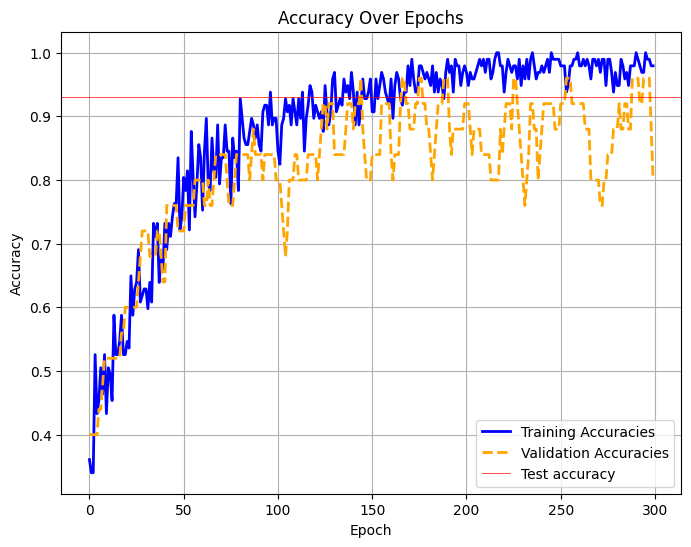

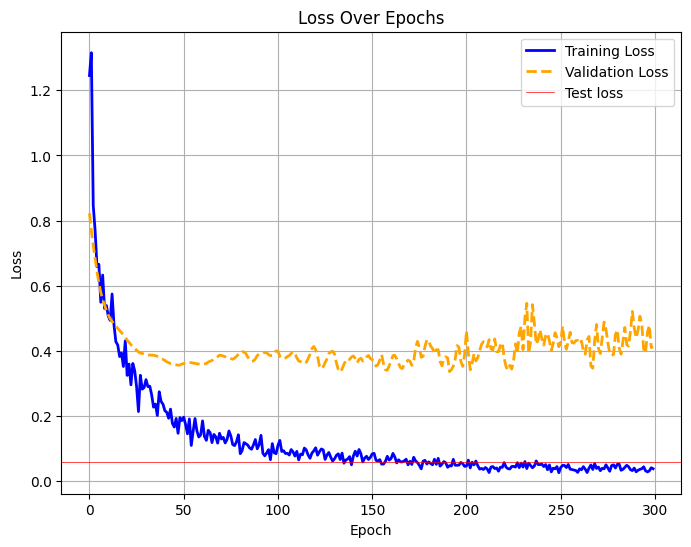

In [23]:
plot_accuracies(train_accuracies, val_accuracies, test_accuracy, label1="Training Accuracies",
                label2="Validation Accuracies", title="Accuracy Over Epochs")
plot_losses(train_losses, val_losses, test_loss, label1="Training Loss",
            label2="Validation Loss", title="Loss Over Epochs")

./data/Monk_3/


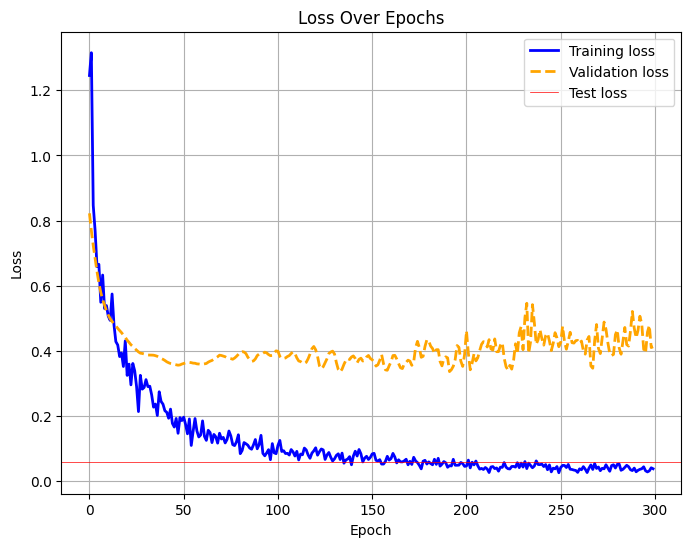

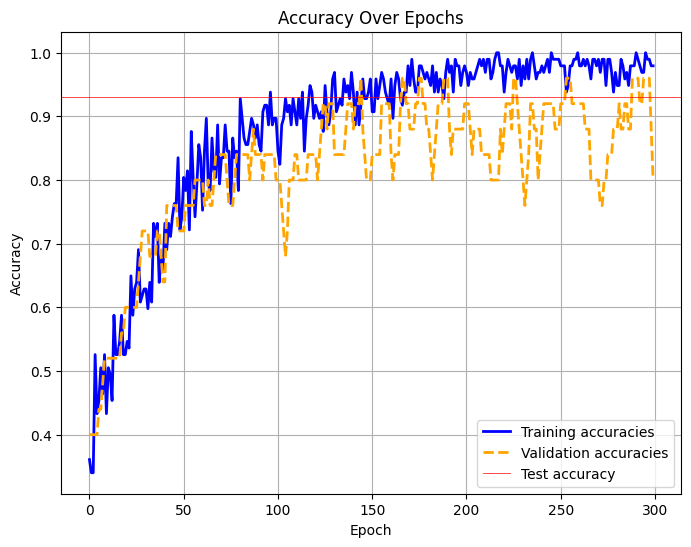

In [24]:

metrics = {
    "train_loss" : train_losses,
    "validation_loss" : val_losses,
    "test_loss" : test_loss,
    "train_accuracy" : train_accuracies,
    "validation_accuracy" : val_accuracies,
    "test_accuracy" : test_accuracy
}
save_results(f"Monk_{MONK_NUM}", model, best_hyperparams, metrics, save_accuracies=True)

In [25]:
print(train_losses, val_losses)

[np.float64(1.2456561741359362), np.float64(1.3156058882555677), np.float64(0.8470359071520478), np.float64(0.7690354304239585), np.float64(0.6589379650928598), np.float64(0.6656940147674754), np.float64(0.5491369795642503), np.float64(0.6326896839722014), np.float64(0.5298805444157115), np.float64(0.5390472337734077), np.float64(0.5057039237363979), np.float64(0.49349519552924637), np.float64(0.5744936921668933), np.float64(0.4803998523650825), np.float64(0.428210703255742), np.float64(0.41787849733759025), np.float64(0.3823694181118807), np.float64(0.39343818164428584), np.float64(0.3518274709378648), np.float64(0.43075424680615254), np.float64(0.3245209570904475), np.float64(0.3590945201003422), np.float64(0.29548091555584705), np.float64(0.36107389029605824), np.float64(0.33858960447977166), np.float64(0.28980066602491783), np.float64(0.21334858546328397), np.float64(0.32473250325251307), np.float64(0.28225954772205075), np.float64(0.2872929186207651), np.float64(0.3115047763463701

In [26]:
# print(np.argmax(test_accuracies))
# print(test_accuracies[np.argmax(test_accuracies)])
# # print(len(test_accuracies))
# # print(best_hyperparams[15])

In [27]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9306


In [28]:
# n_epochs = 350
# batch_size = 1


# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# # early_stopping = EarlyStopping(
# #     patience=20,
# #     min_delta_loss=0.0001,
# #     min_delta_accuracy=0.0001,
# #     restore_best_weights=True
# # )

# # Training loop
# for epoch in range(n_epochs):
#     batch_losses = []
#     batch_accuracies = []
    
#     # Mini-batch training
#     for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#         # Forward pass
#         dense1.forward(X_batch)
#         activation4.forward(dense1.output)
#         dense2.forward(activation4.output)
#         loss = loss_activation.forward(dense2.output, y_batch)
        
#         # Calculate accuracy for this batch
#         predictions = np.argmax(loss_activation.output, axis=1)
#         if len(y_batch.shape) == 2:
#             y_true = np.argmax(y_batch, axis=1)
#         else:
#             y_true = y_batch
#         accuracy = np.mean(predictions == y_true)
        
#         # Backward pass
#         loss_activation.backward(loss_activation.output, y_batch)
#         dense2.backward(loss_activation.dinputs)
#         activation4.backward(dense2.dinputs)
#         dense1.backward(activation4.dinputs)
        
#         # Update weights and biases
#         optimizer.pre_update_params()
#         optimizer.update_params(dense1)
#         optimizer.update_params(dense2)
#         optimizer.post_update_params()
        
#         batch_losses.append(loss)
#         batch_accuracies.append(accuracy)
    
#     # Calculate epoch-level training metrics
#     epoch_loss = np.mean(batch_losses)
#     epoch_accuracy = np.mean(batch_accuracies)
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_accuracy)

#     # Validation pass (entire validation dataset)
#     dense1.forward(X_val)
#     activation4.forward(dense1.output)
#     dense2.forward(activation4.output)
#     val_loss = loss_activation.forward(dense2.output, y_val)
    
#     # Calculate validation accuracy
#     val_predictions = np.argmax(loss_activation.output, axis=1)
#     if len(y_val.shape) == 2:
#         y_val_true = np.argmax(y_val, axis=1)
#     else:
#         y_val_true = y_val
#     val_accuracy = np.mean(val_predictions == y_val_true)
    
#     # Append validation metrics
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)
    
#     # early_stopping.on_epoch_end(
#     #     current_loss=val_loss,
#     #     current_accuracy=val_accuracy,
#     #     model=[dense1, dense2], 
#     #     epoch=epoch
#     # )
#     # if early_stopping.stop_training:
#     #     print(f"Early stopping at epoch {epoch}")
#     #     break
    
#     # Print progress
#     if not epoch % 100:
#         print(f"epoch: {epoch}, "
#               f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
#               f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
#               f"learning_rate: {optimizer.current_learning_rate}")

# plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
# plot_accuracies(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")